In [7]:
import os
import sys
import time
import re
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.environ['LOCAL_RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12345'

sys.path.append(os.path.abspath('..'))

try:
    from config import get_config
    from models import build_model
except ImportError:
    print("Error: Could not import 'config' or 'models'. Make sure you are in the Swin-Transformer project root or correct the path.")

[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.
Tutel has not been installed. To use Swin-MoE, please install Tutel; otherwise, just ignore this.


/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
# Check for acceleration (MPS for Mac, CUDA for NVIDIA, or CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using NVIDIA GPU ({torch.cuda.get_device_name(0)})")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Metal acceleration (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple Metal acceleration (MPS)


In [5]:
class Args:
    cfg = "../configs/swin/chest_xray_finetune.yaml"  
    opts = ["MODEL.NUM_CLASSES", "2"]
    batch_size = 32
    data_path = ""  
    zip = False
    cache_mode = "part"
    pretrained = ""
    resume = ""
    accumulation_steps = 1
    use_checkpoint = False
    amp_opt_level = ""
    output = "output"
    tag = "default"
    eval = True
    throughput = False
    enable_amp = False
    fused_window_process = False
    fused_layernorm = False
    optim = "adamw"
    local_rank = 0

Lettura log in corso...


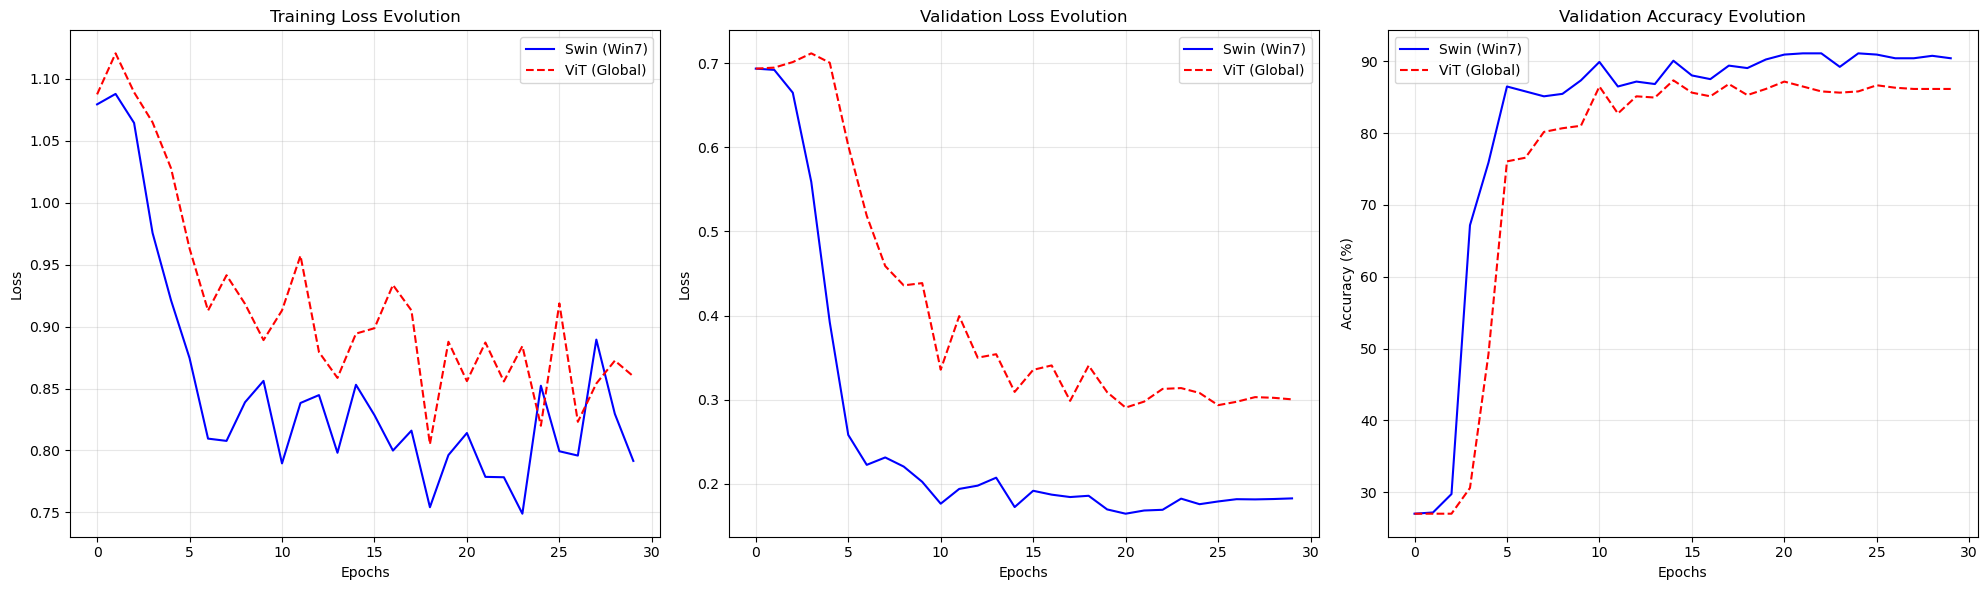

Grafico salvato come 'swin_vs_vit_training_history.png'


In [ ]:
swin_log_path = 'results/swin/log_rank0.txt' 
vit_log_path = 'results/vit/log_rank0.txt'


def parse_training_log(file_path):
    """Legge il file di log ed estrae le metriche per epoca."""
    
    if not os.path.exists(file_path):
        print(f"File non trovato: {file_path}")
        return None

    data = {
        'epochs': [],
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }
    
    train_pattern = re.compile(r'Train: \[(\d+)/\d+\]\[\d+/\d+\].*loss (\d+\.\d+)')
    test_pattern = re.compile(r'Test: \[(\d+)/\d+\].*Loss (\d+\.\d+)')
    acc_pattern = re.compile(r'\* Acc@1 (\d+\.\d+)')

    current_epoch_train_losses = []
    temp_val_losses = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()

    current_epoch = -1
    
    for line in lines:
        match_train = train_pattern.search(line)
        if match_train:
            epoch = int(match_train.group(1))
            loss = float(match_train.group(2))
            
            if epoch != current_epoch:
                if current_epoch_train_losses:
                    data['train_loss'].append(np.mean(current_epoch_train_losses))
                    data['epochs'].append(current_epoch)
                current_epoch = epoch
                current_epoch_train_losses = []
            
            current_epoch_train_losses.append(loss)

        match_test = test_pattern.search(line)
        if match_test:
            loss = float(match_test.group(2))
            temp_val_losses.append(loss)

        match_acc = acc_pattern.search(line)
        if match_acc:
            acc = float(match_acc.group(1))
            
            data['val_acc'].append(acc)
            
            if temp_val_losses:
                data['val_loss'].append(np.mean(temp_val_losses))
                temp_val_losses = []
            else:
                data['val_loss'].append(0.0) 

    if current_epoch_train_losses and len(data['train_loss']) < len(data['epochs']) + 1:
        data['train_loss'].append(np.mean(current_epoch_train_losses))
        data['epochs'].append(current_epoch)

    min_len = min(len(data['epochs']), len(data['train_loss']), len(data['val_acc']))
    data['epochs'] = data['epochs'][:min_len]
    data['train_loss'] = data['train_loss'][:min_len]
    data['val_loss'] = data['val_loss'][:min_len]
    data['val_acc'] = data['val_acc'][:min_len]
    
    return data



print("Reading logs...")
swin_data = parse_training_log(swin_log_path)
vit_data = parse_training_log(vit_log_path)

if swin_data is None and vit_data is None:
    print("No log files found.")
else:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    axes[0].set_title("Training Loss Evolution")
    if swin_data:
        axes[0].plot(swin_data['epochs'], swin_data['train_loss'], 'b-', label='Swin (Win7)')
    if vit_data:
        axes[0].plot(vit_data['epochs'], vit_data['train_loss'], 'r--', label='ViT (Global)')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    axes[1].set_title("Validation Loss Evolution")
    if swin_data:
        axes[1].plot(swin_data['epochs'], swin_data['val_loss'], 'b-', label='Swin (Win7)')
    if vit_data:
        axes[1].plot(vit_data['epochs'], vit_data['val_loss'], 'r--', label='ViT (Global)')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    axes[2].set_title("Validation Accuracy Evolution")
    if swin_data:
        axes[2].plot(swin_data['epochs'], swin_data['val_acc'], 'b-', label='Swin (Win7)')
    if vit_data:
        axes[2].plot(vit_data['epochs'], vit_data['val_acc'], 'r--', label='ViT (Global)')
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("Accuracy (%)")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.savefig("swin_vs_vit_training_history.png")
    plt.show()
    print("Plot saved as 'swin_vs_vit_training_history.png'")


In [5]:
def evaluate_model(model_name, config_path, checkpoint_path, test_loader, classes):
    print(f"\n{'='*20} EVALUATING: {model_name} {'='*20}")
    
    # 1. Setup Config & Model
    args = Args()
    args.cfg = config_path # Impostiamo il config specifico (Swin o ViT)
    
    # Verifica esistenza file
    if not os.path.exists(config_path):
        print(f"Config not found: {config_path}")
        return None
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None

    config = get_config(args)
    print(f"Building model (Window Size: {config.MODEL.SWIN.WINDOW_SIZE})...")
    model = build_model(config)

    # 2. Load Weights
    print(f"Loading weights from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint['model'] if 'model' in checkpoint else checkpoint
    msg = model.load_state_dict(state_dict, strict=False)
    # print(f"Load msg: {msg}")

    model.to(device)
    model.eval()

    # 3. Inference Loop
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    preds_np = np.array(all_preds)
    targets_np = np.array(all_targets)

    # 4. Metrics
    cm = confusion_matrix(targets_np, preds_np)
    tn, fp, fn, tp = cm.ravel()
    
    metrics = {
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'cm': cm,
        'preds': preds_np,
        'targets': targets_np
    }
    
    print(f"Accuracy: {metrics['accuracy']:.2%}")
    return metrics

Loading Test Data from ../dataset/chest_xray_new/test...

==================== EVALUATING: Swin (Window 7) ====================
=> merge config from ../configs/swin/chest_xray_finetune.yaml
Building model (Window Size: 7)...


/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading weights from: results/swin/ckpt_best.pth


/var/folders/c4/m_6w9kxs5kj6jyfn6b9_dsbr0000gn/T/ipykernel_47842/476988980.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Accuracy: 89.78%

==================== EVALUATING: ViT-Sim (Window 56) ====================
=> merge config from ../configs/swin/chest_xray_vit.yaml
Building model (Window Size: 56)...
Loading weights from: results/vit/ckpt_best.pth


/var/folders/c4/m_6w9kxs5kj6jyfn6b9_dsbr0000gn/T/ipykernel_47842/476988980.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Accuracy: 86.03%

COMPARISON RESULTS


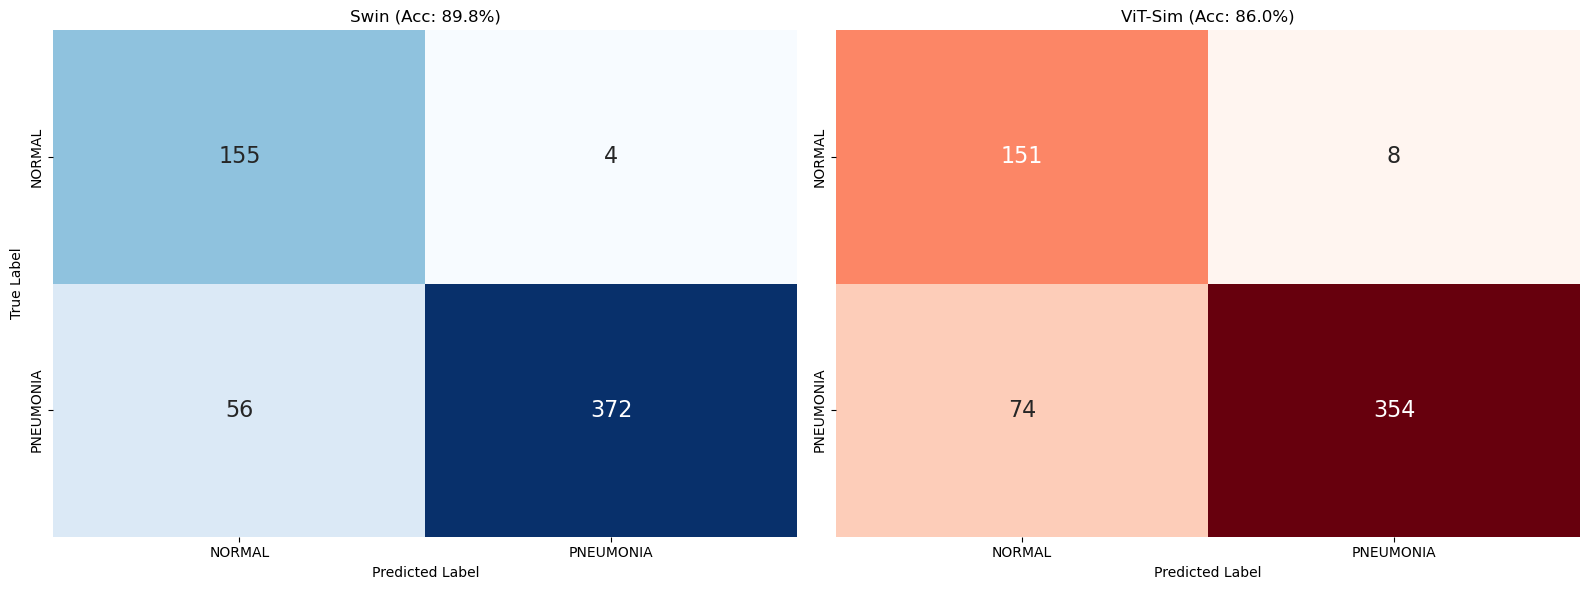

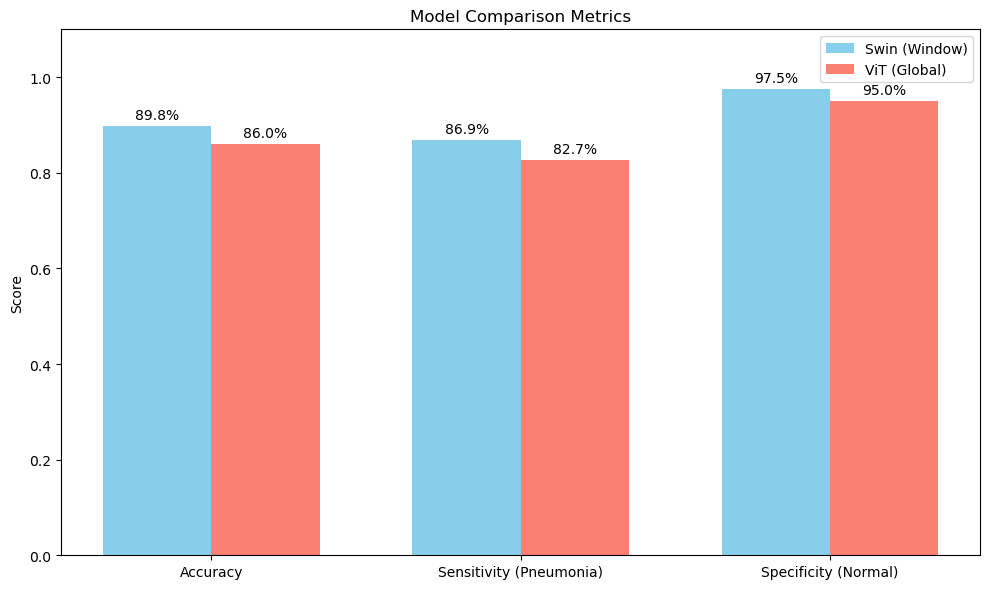

: 

In [ ]:
def main():
    # --- PATHS (Modifica questi percorsi se necessario) ---
    test_dir = "../dataset/chest_xray_new/test"
    
    # PERCORSI SWIN (Standard)
    swin_cfg = "../configs/swin/chest_xray_finetune.yaml"
    swin_ckpt = "results/swin/ckpt_best.pth"
    # PERCORSI VIT (Simulato)
    vit_cfg = "../configs/swin/chest_xray_vit.yaml"
    vit_ckpt = "results/vit/ckpt_best.pth"
    
    # --- DATA LOADING (Comune per entrambi) ---
    print(f"Loading Test Data from {test_dir}...")
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    classes = test_dataset.classes

    # --- RUN EVALUATIONS ---
    results_swin = evaluate_model("Swin (Window 7)", swin_cfg, swin_ckpt, test_loader, classes)
    results_vit = evaluate_model("ViT-Sim (Window 56)", vit_cfg, vit_ckpt, test_loader, classes)

    if results_swin is None or results_vit is None:
        print("Impossibile procedere col confronto: mancano dei file.")
        return

    print("\n" + "="*50)
    print("COMPARISON RESULTS")
    print("="*50)

    # --- PLOT 1: CONFUSION MATRICES SIDE-BY-SIDE ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Swin Plot
    sns.heatmap(results_swin['cm'], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
    axes[0].set_title(f"Swin (Acc: {results_swin['accuracy']:.1%})")
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # ViT Plot
    sns.heatmap(results_vit['cm'], annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[1],
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
    axes[1].set_title(f"ViT-Sim (Acc: {results_vit['accuracy']:.1%})")
    axes[1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    # --- PLOT 2: METRICS BAR CHART ---
    labels = ['Accuracy', 'Sensitivity (Pneumonia)', 'Specificity (Normal)']
    
    swin_vals = [results_swin['accuracy'], results_swin['sensitivity'], results_swin['specificity']]
    vit_vals = [results_vit['accuracy'], results_vit['sensitivity'], results_vit['specificity']]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, swin_vals, width, label='Swin (Window)', color='skyblue')
    rects2 = ax.bar(x + width/2, vit_vals, width, label='ViT (Global)', color='salmon')

    ax.set_ylabel('Score')
    ax.set_title('Model Comparison Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, 1.1) # Asse Y fino a 1.1 per far stare le etichette

    # Funzione per etichette sulle barre
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1%}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Res        | Swin Mem (GB)   | ViT Mem (GB)   
---------------------------------------------


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'memory_worker' on <module '__main__' (built-in)>


224x224    | CRASH (OOM)     | CRASH (OOM) 💥  


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'memory_worker' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'memory_worker' on <module '__main__' (built-in)>


336x336    | CRASH (OOM)     | CRASH (OOM) 💥  


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'memory_worker' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'memory_worker' on <module '__main__' (built-in)>


448x448    | CRASH (OOM)     | CRASH (OOM) 💥  


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'memory_worker' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'memory_worker' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "

560x560    | CRASH (OOM)     | CRASH (OOM) 💥  


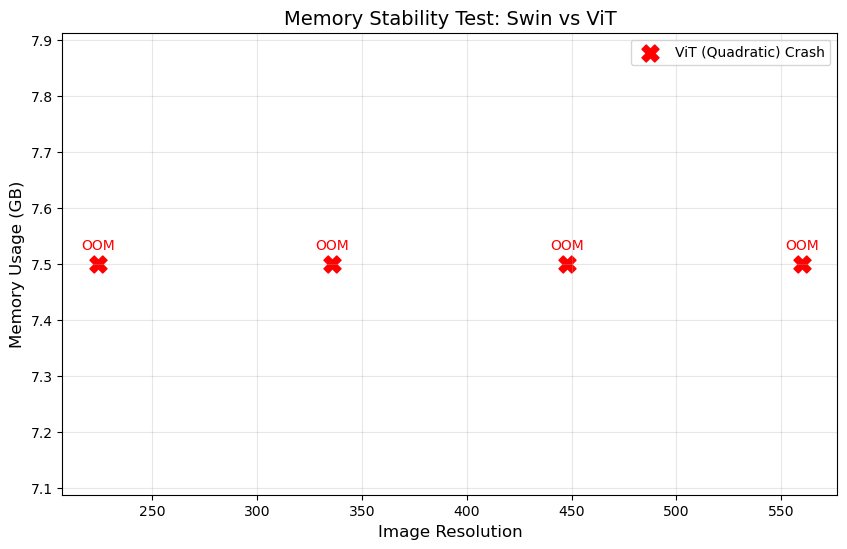

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import sys
import multiprocessing

# Aggiungi il path per trovare i moduli custom
sys.path.append(os.path.abspath('..'))

# --- FUNZIONE WORKER (Eseguita in un processo separato) ---
def memory_worker(model_type, img_size, window_size, queue):
    """
    Questa funzione viene lanciata in un processo isolato.
    Se crasha qui, il processo principale NON muore.
    """
    try:
        # Importiamo qui per avere un ambiente pulito ogni volta
        from config import get_config
        from models import build_model
        
        # Setup Device (Rilevato fresco nel processo)
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        elif torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

        # Configurazione Mock
        class Args:
            cfg = "../configs/swin/chest_xray_finetune.yaml" 
            opts = [
                "DATA.IMG_SIZE", str(img_size),
                "MODEL.SWIN.WINDOW_SIZE", str(window_size),
                "MODEL.NUM_CLASSES", "2"
            ]
            batch_size = 1 
            data_path = ""
            zip = False
            cache_mode = "part"
            pretrained = ""
            resume = ""
            accumulation_steps = 1
            use_checkpoint = False 
            amp_opt_level = ""
            output = "output"
            tag = "mem_test"
            eval = True
            throughput = False
            enable_amp = False
            fused_window_process = False
            fused_layernorm = False
            optim = "adamw"
            local_rank = 0

        # Costruisci modello
        args = Args()
        config = get_config(args)
        
        # Patch manuale parametri per sicurezza
        config.defrost()
        config.DATA.IMG_SIZE = img_size
        config.MODEL.SWIN.WINDOW_SIZE = window_size
        config.freeze()

        model = build_model(config)
        model.to(device)
        model.eval()
        
        # Input Dummy
        input_tensor = torch.randn(1, 3, img_size, img_size).to(device)
        
        # Warmup (opzionale)
        with torch.no_grad():
            _ = model(input_tensor)
        
        # Misura Memoria
        mem_usage = 0.0
        if device.type == 'mps':
            mem_usage = torch.mps.current_allocated_memory() / (1024 ** 3)
        elif device.type == 'cuda':
            mem_usage = torch.cuda.max_memory_allocated() / (1024 ** 3)
        
        # Invia il risultato al processo padre
        queue.put(mem_usage)
        
    except Exception as e:
        # Se c'è un errore Python (non crash di sistema), lo mandiamo
        queue.put(f"Error: {str(e)}")

# --- FUNZIONE PRINCIPALE DI CONTROLLO ---
def run_safe_experiment():
    # Risoluzioni (Multipli di 28 per Swin)
    resolutions = [224, 336, 448, 560]
    
    swin_results = []
    vit_results = []

    print(f"\n{'Res':<10} | {'Swin Mem (GB)':<15} | {'ViT Mem (GB)':<15}")
    print("-" * 45)

    for res in resolutions:
        # --- TEST 1: SWIN ---
        q_swin = multiprocessing.Queue()
        p_swin = multiprocessing.Process(target=memory_worker, args=("Swin", res, 7, q_swin))
        p_swin.start()
        p_swin.join() # Aspetta che finisca
        
        mem_s = None
        if p_swin.exitcode != 0:
            s_str = "CRASH (OOM)"
        elif not q_swin.empty():
            res_s = q_swin.get()
            if isinstance(res_s, str): s_str = "Error" # Errore Python
            else: 
                mem_s = res_s
                s_str = f"{mem_s:.3f}"
        else:
            s_str = "Unknown"
        swin_results.append(mem_s)

        # --- TEST 2: ViT ---
        global_window = res // 4
        q_vit = multiprocessing.Queue()
        p_vit = multiprocessing.Process(target=memory_worker, args=("ViT", res, global_window, q_vit))
        p_vit.start()
        p_vit.join()
        
        mem_v = None
        if p_vit.exitcode != 0:
            v_str = "CRASH (OOM) 💥" # Il crash che cercavamo!
            mem_v = -1 # Flag per il plot
        elif not q_vit.empty():
            res_v = q_vit.get()
            if isinstance(res_v, str): 
                v_str = "Error"
                # print(f"DEBUG ViT Error: {res_v}")
            else: 
                mem_v = res_v
                v_str = f"{mem_v:.3f}"
        else:
            v_str = "Unknown"
        vit_results.append(mem_v)

        print(f"{res}x{res:<6} | {s_str:<15} | {v_str:<15}")

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))

    def plot_line(data, color, label, marker):
        valid_x = []
        valid_y = []
        crashes_x = []
        
        for r, m in zip(resolutions, data):
            if m is not None and m != -1:
                valid_x.append(r)
                valid_y.append(m)
            elif m == -1:
                crashes_x.append(r)
        
        if valid_x:
            plt.plot(valid_x, valid_y, marker=marker, color=color, linewidth=2, label=label)
        
        # Plotta i crash come X rosse in alto
        if crashes_x:
            # Mettiamoli in alto nel grafico per far capire che sono fuori scala
            max_y = max(valid_y) if valid_y else 5
            crash_y = [max_y * 1.5] * len(crashes_x) 
            plt.scatter(crashes_x, crash_y, color=color, marker='X', s=150, label=f"{label} Crash")
            for cx, cy in zip(crashes_x, crash_y):
                plt.annotate("OOM", (cx, cy), xytext=(0, 10), textcoords='offset points', ha='center', color=color)

    plot_line(swin_results, 'blue', 'Swin (Linear)', 'o')
    plot_line(vit_results, 'red', 'ViT (Quadratic)', 'x')

    plt.xlabel('Image Resolution', fontsize=12)
    plt.ylabel('Memory Usage (GB)', fontsize=12)
    plt.title('Memory Stability Test: Swin vs ViT', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('safe_memory_plot.png')
    plt.show()

if __name__ == "__main__":
    # Su macOS è necessario impostare il metodo di start
    try:
        multiprocessing.set_start_method('spawn', force=True)
    except RuntimeError:
        pass
    run_safe_experiment()